In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib import cm
from scipy.special import erfc
import time
import copy
import random
import typing

In [2]:
def analytical_solution(x, t, D, max_range=10):
    """
    Calculate the analytical diffusion solution using the complementary error function.

    Parameters:
    x (array): Spatial coordinates for evaluation (1D array).
    t (float): Time at which to evaluate the solution (must be > 0).
    D (float): Diffusion coefficient (positive value).
    max_range (int, optional): Number of terms in the summation (default 
        is 10).

    Returns an array of analytical solution at the specified spatial 
        points and time.
    """
    sum_analytical = np.zeros_like(x)
    for i in range(max_range):
        sum_analytical += (erfc((1 - x + 2 * i) / (2 * np.sqrt(D * t))) 
                           - erfc((1 + x + 2 * i) / (2 * np.sqrt(D * t))))

    return sum_analytical


In [3]:
def initialize_grid(N: int):
    """
    Initialize a 2D grid of size N x N with the bottom row set to 1.0.
    """
    grid = np.zeros((N, N))
    grid[-1, :] = 1.0
    
    return grid


In [4]:
def get_next_grid(grid, N, dt, D, dx, method, omega):
    """
    Compute the next iteration of the 2D grid based on the specified 
    method.

    Parameters:
    grid (array): The current state of the grid.
    N (int): Size of the grid (number of rows and columns).
    dt (float): Time step for the simulation.
    D (float): Diffusion coefficient.
    dx (float): Spatial step size.
    method (str): The numerical method to use ('Explicit', 'Jacobi', 
        'Gauss-Seidel', or 'SOR').
    omega (float): Relaxation factor for the SOR method.

    Returns (tuple):
        - new_grid (array): The updated grid after applying the numerical 
            method.
        - maximum_difference (float, optional): The maximum difference 
            between the old and new grid values (only for Jacobi, 
            Gauss-Seidel, and SOR methods).
    """
    new_grid = np.copy(grid)

    if method == 'Explicit':
        for i in range(1, N - 1):
            for j in range(N):
                new_grid[i, j] = grid[i, j] + (dt * D / dx**2) * (
                    grid[i - 1, j] + grid[i + 1, j] + grid[i, (j - 1) % N] 
                    + grid[i, (j + 1) % N] - 4 * grid[i, j])
                    
        return new_grid, None

    elif method == 'Jacobi':
        maximum_difference = 0
        for i in range(1, N - 1):
            for j in range(N):
                new_grid[i, j] = 0.25 * (
                    grid[i - 1, j] + grid[i + 1, j] + grid[i, (j - 1) % N] 
                    + grid[i, (j + 1) % N])

                maximum_difference = max(maximum_difference, abs(new_grid[i, j] 
                    - grid[i, j]))

        return new_grid, maximum_difference  

    elif method == 'Gauss-Seidel':
        maximum_difference = 0
        for i in range(1, N - 1):
            for j in range(N):
                old_value = new_grid[i, j]
                new_grid[i, j] = 0.25 * (
                    new_grid[i - 1, j] + grid[i + 1, j] 
                        + new_grid[i, (j - 1) % N] + grid[i, (j + 1) % N]
                )
                maximum_difference = max(maximum_difference, 
                    abs(new_grid[i, j] - old_value))

        return new_grid, maximum_difference  

    elif method == 'SOR':
        maximum_difference = 0
        for i in range(1, N - 1):
            for j in range(N):
                old_value = grid[i, j]

                gauss_seidel_value = 0.25 * (
                    new_grid[i - 1, j] + grid[i + 1, j] 
                    + new_grid[i, (j - 1) % N] + grid[i, (j + 1) % N])

                new_grid[i, j] = ((1 - omega) * old_value 
                    + omega * gauss_seidel_value)

                maximum_difference = max(maximum_difference, 
                    abs(new_grid[i, j] - old_value))

        return new_grid, maximum_difference


In [104]:
def simulate_diffusion_2d(N, D, dx, dt, T, method="Explicit", omega=1.85, tol=1e-5, save_interval=100):
    """
    Simulates the process of diffusion through a 2D grid.

    Parameters:
    N (int): The size of the grid (N x N).
    D (float): The diffusion coefficient.
    dx (float): The grid spacing.
    dt (float): The time step for the simulation.
    T (float): The total time for the simulation.
    method (str, optional): The numerical method for diffusion 
        ('Explicit', 'Jacobi', 'Gauss-Seidel', 'SOR'). 
        Default is 'Explicit'.
    omega (float, optional): The relaxation parameter for SOR 
        (if applicable). Default is 1.85.
    tol (float, optional): The tolerance for convergence 
        (for iterative methods). Default is 1e-5.
    save_interval (int, optional): The interval at which the grid state 
        is saved. Default is 100.

    Returns a list of time points at which the grid states are saved and
        a list of the grid states over time.
    
    (For iterative methods)
    iters (int): The number of iterations taken to converge.
    max_difference (list): Maximum differences between successive 
        iterations.
    """
    c = initialize_grid(N)
    c_history = [c.copy()]

    n_steps = int(T / dt)
    time_points = [0.0]
    special_times = [0.001, 0.01, 0.1, 1.0]

    if method == 'Explicit':
        for step in range(1, n_steps + 1):
            c = get_next_grid(c, N, dt, D, dx, method=method, omega=omega)
            current_time = step * dt

            if (step % save_interval == 0) or any(abs(current_time - t) 
                < dt for t in special_times):

                time_points.append(current_time)
                c_history.append(c.copy())

        return time_points, c_history
    
    elif method in ['Jacobi', 'Gauss-Seidel', 'SOR']:
        iters = 0
        max_difference = []
        while True:  
            c, max_diff = get_next_grid(c, N, dt, D, dx, method=method, 
                omega=omega)
            
            if iters % save_interval == 0:
                c_history.append(c.copy())
                
            if max_diff < tol:
                print(f"Converged after {iters} iterations")
                break

            max_difference.append(max_diff)
            iters += 1
            
        return iters, c_history, max_difference   

In [6]:
def validate_against_analytical(x_points, times, D, c_history, N):
    """
    Validate the numerical solution against the analytical solution.

    Parameters:
    x_points (array): Spatial points where the concentration is evaluated.
    times (array): Time instances at which the numerical solutions are 
        available.
    D (float): Diffusion coefficient.
    c_history (list of array): Concentration fields at each time step.
    N (int): Size of the grid (NxN).
    """
    plt.figure(figsize=(12, 8))
    mid_x = N // 2
    
    for i, t in enumerate(times):
        if t > 0:  
            numerical = c_history[i][:, mid_x]
            analytical = np.array([analytical_solution(x, t, D) 
                for x in x_points])
            
            # Plot both solutions
            plt.plot(x_points, numerical, 'o-', label=f'Numerical, t={t:.3f}')
            plt.plot(x_points, analytical, '--', label=f'Analytical, t={t:.3f}')
    
    plt.xlabel('y position')
    plt.ylabel('Concentration c(y)')
    plt.title('Comparison between numerical and analytical solutions')
    plt.legend()
    plt.grid(True)
    plt.savefig('validation_plot.png', dpi=300)
    plt.show()


In [7]:
def plot_2d_concentration(times, c_history, N, dx):
    """
    Plot 2D concentration fields for given time steps.

    Parameters:
    times (array): Time steps at which the concentration fields are 
        evaluated.
    c_history (list of array): Concentration fields at each time step.
    N (int): Size of the grid (NxN).
    dx (float): Spatial resolution of the grid.
    """
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    x = np.linspace(0, (N-1) * dx, N)
    y = np.linspace(0, (N-1) * dx, N)
    X, Y = np.meshgrid(x, y)
    
    for i, (t, c) in enumerate(zip(times, c_history)):
        if i < len(axes):
            ax = axes[i]
            im = ax.pcolormesh(X, Y, c, cmap='viridis', shading='auto')
            ax.set_title(f't = {t:.3f}')
            ax.set_xlabel('x')
            ax.set_ylabel('y')
            fig.colorbar(im, ax=ax, label='Concentration')
    
    plt.tight_layout()
    plt.savefig('concentration_plots.png', dpi=300)
    plt.show()


In [105]:
def create_animation(times, c_history, N, dx):
    """
    Create an animation of the concentration field over time.

    Parameters:
    times (array): Time steps for the animation.
    c_history (list of array): Concentration fields at each time step.
    N (int): Size of the grid (NxN).
    dx (float): Spatial resolution of the grid.

    Returns an animation of the object.
    """
    fig, ax = plt.subplots(figsize=(8, 8))
    
    x = np.linspace(0, (N-1) * dx, N)
    y = np.linspace(0, (N-1) * dx, N)
    X, Y = np.meshgrid(x, y)
    
    im = ax.pcolormesh(X, Y, c_history[0], cmap='viridis', shading='auto', 
        vmin=0, vmax=1)
    title = ax.set_title(f't = {times[0]:.5f}')
    fig.colorbar(im, ax=ax, label='Concentration')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    
    def update(frame):
        im.set_array(c_history[frame].ravel())
        title.set_text(f't = {times[frame]:.5f}')
        
        return [im, title]
    
    ani = FuncAnimation(fig, update, frames=range(len(times)), blit=True)
    ani.save('diffusion_animation.gif', writer='pillow', fps=15)
    plt.show()
    
    return ani


In [106]:
def compare_analytic_solutions(N, L, D, dx, dt, T, method='Explicit'):
    """
    Compare the analytical solution with a numerical method to check simulation accuracy.

    Parameters:
    N (int): Number of grid points in one dimension.
    L (float): Length of the domain.
    D (float): Diffusion coefficient.
    dx (float): Spatial resolution of the grid.
    dt (float): Time step for the simulation.
    T (float): Total simulation time.
    method (str): Numerical method to use ('Explicit' is default).

    Returns an animation object.
    """
    time_points, c_history, _ = simulate_diffusion_2d(N, D, dx, dt, T, method, 
        save_interval=100)
    x_points = np.linspace(0, L, N)
    target_times = [0, 0.001, 0.01, 0.1, 1.0]
    selected_indices = []
    selected_times = []

    for target in target_times:
        # Find indices closest to the target timesteps
        idx = np.argmin(np.abs(np.array(time_points) - target))
        selected_indices.append(idx)
        selected_times.append(time_points[idx])

    validate_against_analytical(x_points, [time_points[i] 
        for i in selected_indices], D, [c_history[i] for i in selected_indices], 
        N)
    plot_2d_concentration([time_points[i] for i in selected_indices], 
        [c_history[i] for i in selected_indices], N, dx)
    ani = create_animation(time_points, c_history, N, dx)
    
    return ani


#### Initial Conditions for the Simulation to be used all throughout the code

In [107]:
N = 50       # Number of grid points in each dimension (50x50 grid)
L = 1.0     # Length of the domain (1.0 unit)
dx = L / N  # Grid spacing (distance between grid points)
D = 1.0     # Diffusion coefficient (controls the rate of diffusion)
dt = 0.25 * dx**2 / D  # Time step size based on stability criteria
T = 1.0     # Total simulation time

In [1]:
def compare_numerical_methods(N, D, dx, dt, T, L, methods=['Jacobi', 
    'Gauss-Seidel', 'SOR'], tol= 1e-5, omega=1.8):
    """
    Compares numerical methods for solving the diffusion equation.
    Plots the concentration profiles for each method against the analytical solution.
    
    Parameters:
    N (int): Number of grid points
    D (float): Diffusion coefficient
    dx (float): Spatial step size
    dt (float): Time step size
    T (float): Final simulation time
    L (float): Length of the domain
    methods (str): List of numerical methods to compare
    omega (float): Relaxation parameter for SOR
    """
    y_values = np.linspace(0, L, N)
    analytic_vals = [float(analytical_solution(y, T, D)) for y in y_values]
    
    plt.figure(figsize=(10, 6))
    
    for method in methods:
        iters, c_history, _ = simulate_diffusion_2d(N, D, dx, dt, T, 
            method=method, tol= tol, omega=omega)
        c_history = np.array(c_history)

        # Midpoint in x-direction
        mid_x = len(c_history[-1]) // 2
        c_values = [row[mid_x] for row in c_history[-1]]
        
        plt.plot(y_values, c_values, label=f'{method} Method', marker='o')
    
    plt.plot(y_values, analytic_vals, label='Analytical Solution', 
        linestyle='--', color='black')

    plt.xlabel('Y Values')
    plt.ylabel('Concentration')
    plt.title(f'Comparison of {method} Method with Analytical Solution' 
              f'after {iters} iterations')
    plt.legend()
    plt.grid()
    plt.show()

### 1.H Comparing different Numerical Methods with Analytical Solution
Successive Over Relaxation requires least amount of iterations $(424)$ to converge at the solution followed by Gauss-Seidel $(2406)$ and Jacobi $(4067)$ Iteration Methods 

Converged after 4067 iterations


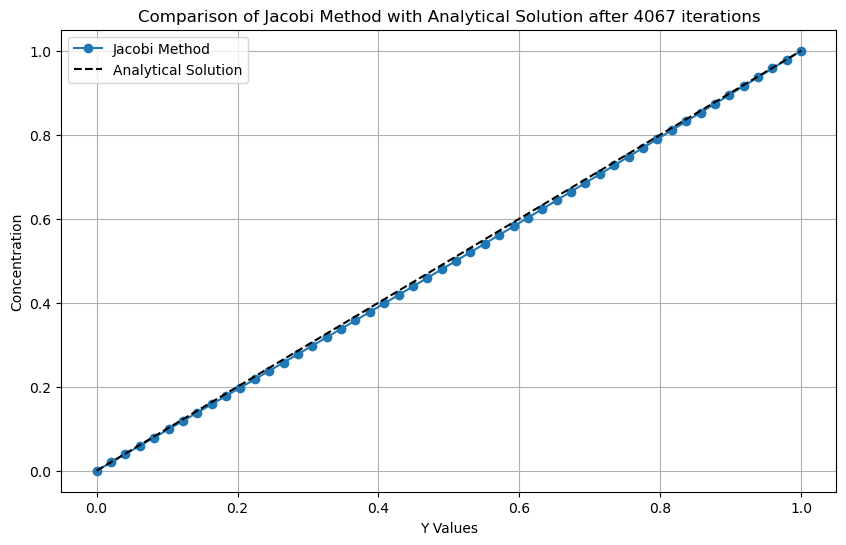

In [20]:
compare_numerical_methods(N, D, dx, dt, T, L, methods=['Jacobi'])

Converged after 2406 iterations


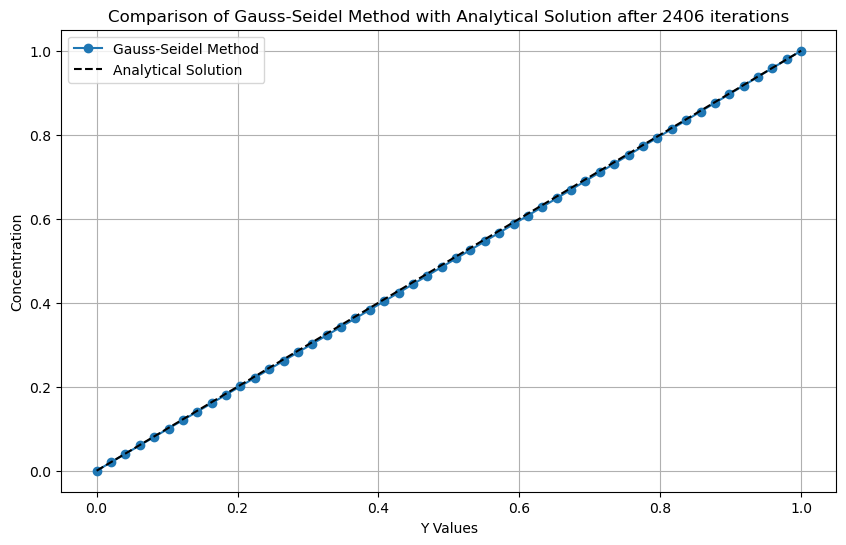

In [21]:
compare_numerical_methods(N, D, dx, dt, T, L, methods=['Gauss-Seidel'])

Converged after 424 iterations


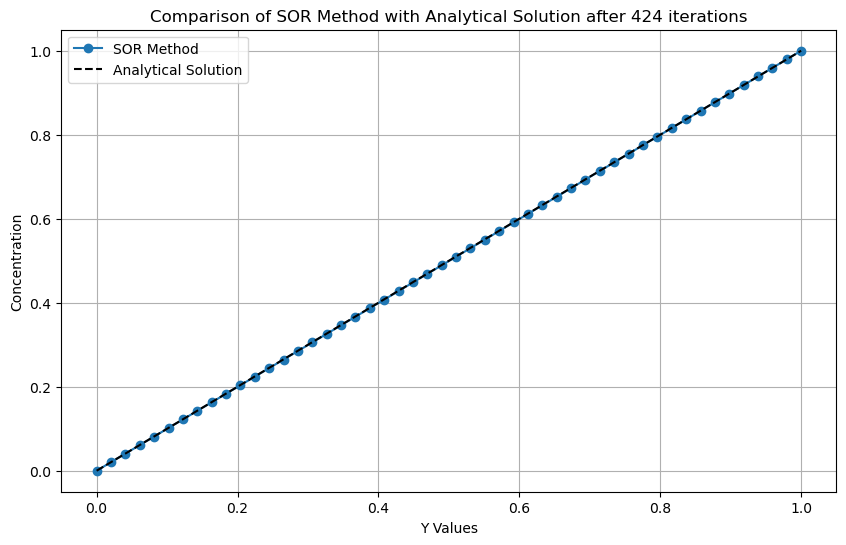

In [22]:
compare_numerical_methods(N, D, dx, dt, T, L, methods=['SOR'], omega=1.8)

### 1.I Showing how convergence mesasure depends on the number of iterations $k$

In [23]:
def compare_iterative_methods(N, D, dx, dt, T, tol=1e-5, save_interval=1):
    """
    Compare convergence of Jacobi, Gauss-Seidel, and SOR methods
    
    Parameters:
    N (int): Grid size
    D (float): Diffusion coefficient
    dx (float): Grid spacing
    dt (float): ime step
    T (float): Total simulation time
    tol (float): Convergence tolerance
    save_interval (int): Interval for saving convergence data
        
    Returns a plot comparing convergence of different methods
    """
    results = {}

    iters, _, max_diff = simulate_diffusion_2d(N, D, dx, dt, T, method='Jacobi', 
        tol=tol)
    results['Jacobi'] = max_diff

    iters, _, max_diff = simulate_diffusion_2d(N, D, dx, dt, T, 
        method='Gauss-Seidel', tol=tol)
    results['Gauss-Seidel'] = max_diff
    
    omega_values = [1.5, 1.65, 1.8]
    for omega in omega_values:
        iters, _, max_diff = simulate_diffusion_2d(N, D, dx, dt, T, 
            method='SOR', omega=omega, tol=tol)
        results[f'SOR (ω={omega})'] = max_diff
    
    # Create plot
    plt.figure(figsize=(12, 8))
    
    # Plot each method
    for method, max_diff in results.items():
        iterations = np.arange(len(max_diff))
        plt.plot(iterations, max_diff, label=method)
    
    plt.xlabel('Iteration')
    plt.ylabel('Maximum Difference')
    plt.title('Convergence Comparison of Iterative Methods')
    plt.yscale('log')  
    plt.grid(True)
    plt.legend()
    
   
    plt.savefig('convergence_comparison.png', dpi=300)
    plt.show()  
    
    return plt.gcf()  


Converged after 4067 iterations
Converged after 2406 iterations
Converged after 1008 iterations
Converged after 704 iterations
Converged after 424 iterations


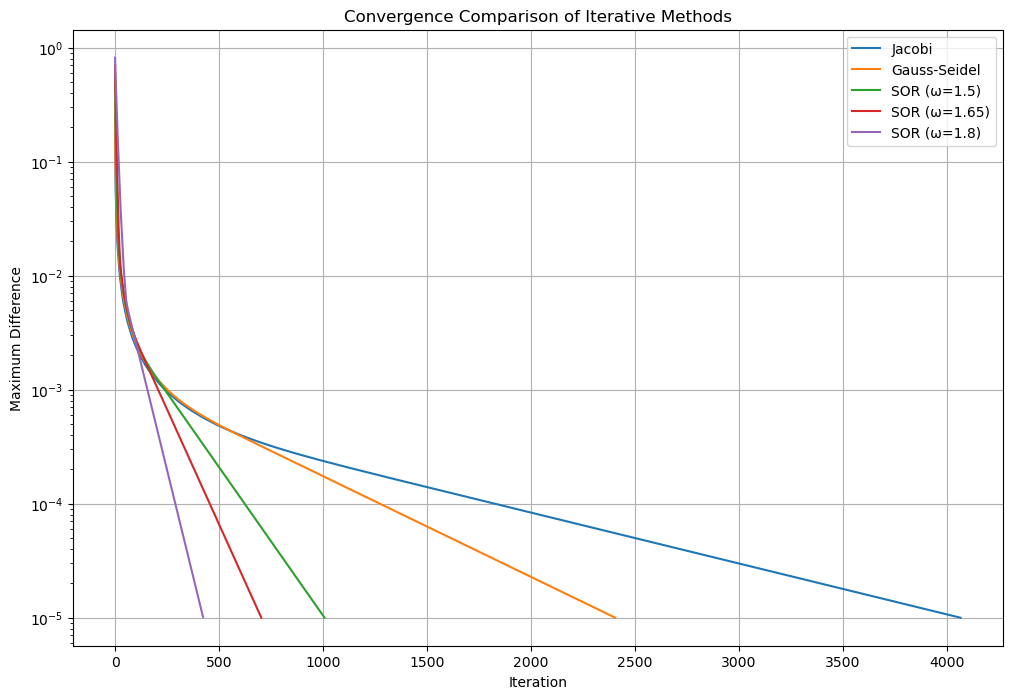

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [24]:
compare_iterative_methods(N, D, dx, dt, T, tol=1e-5)

In [108]:
def tolerances_comparison(N, D, dx, dt, T, tol_values=None, omega=1.7):
    """
    Compare the number of iterations needed for convergence across different numerical methods
    with varying tolerance values.

    Parameters:
    N (int): Number of grid points in each dimension.
    D (float): Diffusion coefficient.
    dx (float): Grid spacing.
    dt (float): Time step size.
    T (float): Total simulation time.
    tol_values (list, optional): Tolerance values to test 
        (logarithmically spaced if None).
    omega (float, optional): Relaxation parameter for SOR method 
        (default is 1.7).
    """
     # Generate logarithmically spaced tolerance values
    if tol_values is None:
        tol_values = np.logspace(-5, -14, 6)

    methods = ['Jacobi', 'Gauss-Seidel', 'SOR']
    iter_counts = {method: [] for method in methods}

    for method in methods:
        for tol in tol_values:
            iters, _ ,_= simulate_diffusion_2d(N, D, dx, dt, T, method=method, 
                tol=tol, omega=omega)
            iter_counts[method].append(iters)

 
    fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

    for i, method in enumerate(methods):
        axes[i].plot(tol_values, iter_counts[method], marker='o', linestyle='-')
        axes[i].set_xscale('log')  
        axes[i].set_xlabel('Tolerance')
        axes[i].set_title(f'{method} Method')
        axes[i].grid(True)

    axes[0].set_ylabel('Iterations')
    plt.suptitle('Iterations needed to converge vs. Tolerance for Different '
                 'Methods')
    plt.tight_layout()
    plt.show()

Converged after 4067 iterations
Converged after 7987 iterations
Converged after 11908 iterations
Converged after 15828 iterations
Converged after 19749 iterations
Converged after 2406 iterations
Converged after 4387 iterations
Converged after 6367 iterations
Converged after 8348 iterations
Converged after 10328 iterations
Converged after 609 iterations
Converged after 973 iterations
Converged after 1336 iterations
Converged after 1700 iterations
Converged after 2064 iterations


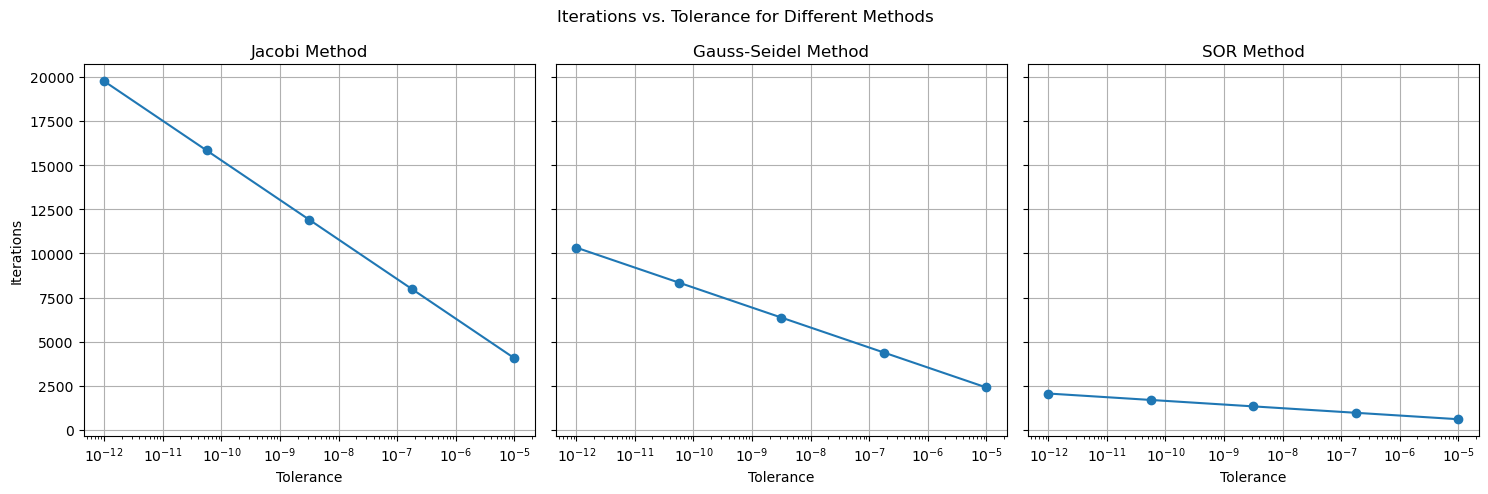

In [264]:
tol_values = np.logspace(-5, -12, 5)
tolerances_comparison(N, D, dx, dt, T, tol_values)

### 1.J Finding Optimal $(\omega)$ for minimum number of Iterations in the SOR Method

In [109]:
def optimal_omega(N, D, dx, dt, T, tol=1e-5, omega_list=None):
    """
    Find the optimal relaxation parameter (ω) for the SOR method based on 
    the number of iterations required for convergence.

    Parameters:
    N (int): Grid size
    D (float): Diffusion coefficient
    dx (float): Grid spacing
    dt (float): Time step
    T (float): Total simulation time
    tol (float): Convergence tolerance (default is 1e-5).
    omega_list (array, optional): Omega values to test (default is a 
        linear space from 1.1 to 1.9).

    Returns a float of the optimal relaxation parameter (ω) that 
        minimizes the number of iterations.
    """
    # Use a default range of omega values if none is provided
    if omega_list is None:
        omega_list = np.linspace(1.1, 1.9, 20)
    
    iterations = []

    for omega in omega_list:
        iters, _ ,_= simulate_diffusion_2d(N, D, dx, dt, T, method='SOR', 
            tol=tol, omega=omega)
        iterations.append(iters)
    
    plt.figure(figsize=(8, 5))
    plt.plot(omega_list, iterations, marker='o', linestyle='-')
    plt.xlabel('ω (Relaxation Parameter)')
    plt.ylabel('Number of Iterations')
    plt.title(f'Convergence Iterations vs. ω for N = {N}')
    plt.grid(True)
    plt.show()
    
    optimal_idx = np.argmin(iterations)
    optimal_value = omega_list[optimal_idx]
    print(f'Optimal ω: {optimal_value} with {iterations[optimal_idx]} '
           'iterations')
    
    return optimal_value


Converged after 424 iterations
Converged after 415 iterations
Converged after 405 iterations
Converged after 396 iterations
Converged after 386 iterations
Converged after 377 iterations
Converged after 367 iterations
Converged after 358 iterations
Converged after 348 iterations
Converged after 338 iterations
Converged after 329 iterations
Converged after 319 iterations
Converged after 310 iterations
Converged after 300 iterations
Converged after 290 iterations
Converged after 281 iterations
Converged after 274 iterations
Converged after 274 iterations
Converged after 281 iterations
Converged after 312 iterations


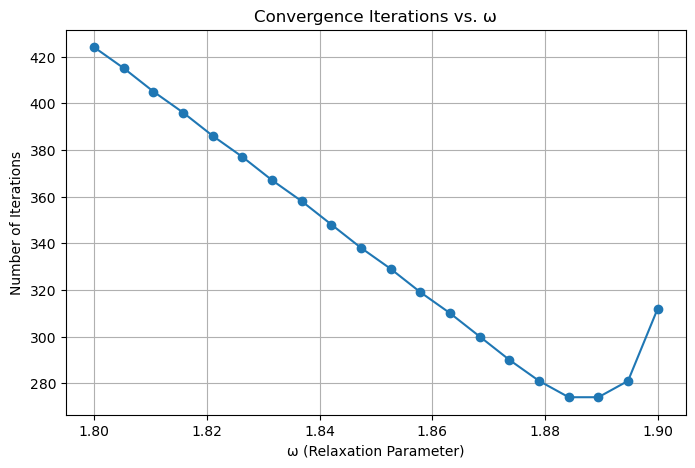

Optimal ω: 1.8842105263157893 with 274 iterations


1.8842105263157893

In [277]:
omega_list = np.linspace(1.8, 1.90, 20)
optimal_omega(N, D, dx, dt, T, tol=1e-5, omega_list= omega_list)

In [2]:
def plot_omega_vs_N(N_values, D, dt, T, tol=1e-5, omega_list=None):
    """Plots grid size (NxN) verses the optimal omega value."""
    if omega_list is None:
        omega_list = np.linspace(1.5, 2.0, 10)  

    optimal_omegas = []  

    plt.figure(figsize=(8, 5))

    for N in N_values:
        iterations = []
        count = 0
        for omega in omega_list:
            iters, _, _ = simulate_diffusion_2d(N, D, 1/N , dt, T, method='SOR', tol=tol, omega=omega)

            if len(iterations) > 1 and iters > 10 * iterations[-1]:
                break
            iterations.append(iters)

        # Find optimal ω for this N
        optimal_idx = np.argmin(iterations)
        optimal_value = omega_list[optimal_idx]
        optimal_omegas.append(optimal_value)

        print(f"For N={N}, Optimal ω: {optimal_value} with {iterations[optimal_idx]} iterations")

    # Plot N vs optimal omega
    plt.figure(figsize=(8, 5))
    plt.plot(N_values, optimal_omegas, marker='o', linestyle='-', color='blue')
    plt.xlabel('Grid Size N')
    plt.ylabel('Optimal ω (Relaxation Parameter)')
    plt.title('Optimal ω vs. Grid Size N')
    plt.grid(True)
    plt.show()

    return optimal_omegas

In [ ]:

# Example parameters for running the function
N_values = [10, 30, 50, 100]


plot_omega_vs_N(N_values, D, dt, T)

### 1.K Implementing Sinks in the Grid

In [67]:
def check_in_mask(i, j, dx, mask_center, mask_dims, mask_type):
    """
    Checks if a point is inside the mask. Returns a boolean True if it is.
    """
    if mask_type == 'rectangle':
        x, y = i * dx, j * dx
        mask_x, mask_y = mask_center
        mask_width, mask_height = mask_dims
        
        return (abs(x - mask_x) <= mask_width / 2 and 
                abs(y - mask_y) <= mask_height / 2)

    return False

In [79]:
def get_next_grid_mask(grid, N, dt, D, dx, method, omega, mask_center,
    mask_dims, mask_type):
    """
    Performs one iteration of the SOR method to update the grid while 
    respecting the mask.

    Parameters:
    grid (array): Represents the grid
    N (int): Grid size (assumes square NxN grid)
    dt (float): Time step (not used directly in SOR)
    D (float) Diffusion coefficient (not used directly in SOR)
    dx (float): Grid spacing
    method (str): Numerical method ('SOR' supported)
    omega (float): Relaxation parameter for SOR
    mask_center (Tuple): Tuple (x_center, y_center) for mask
    mask_dims: Size of the mask (L for square, R for circle)
    mask_type: 'Square' or 'Circle'

    Returns an updated grid after one iteration and the maximum change 
        in grid values (for convergence tracking)
    """
    new_grid = np.copy(grid)
    maximum_difference = 0

    if method == 'SOR':
        # Interior points only
        for i in range(1, N-1):
            # Full range (with periodic BCs in y-direction)
            for j in range(N):

                # Only update if not masked
                if not check_in_mask(i, j, dx, mask_center, mask_dims, mask_type):
                    old_value = grid[i, j]
                    gauss_seidel_value = 0.25 * (new_grid[i-1, j] + grid[i+1, j] 
                        +  new_grid[i, (j-1) % N] + grid[i, (j+1) % N])
                    new_grid[i, j] = ((1 - omega) * old_value + omega 
                        * gauss_seidel_value)
                    maximum_difference = max(maximum_difference, 
                        abs(new_grid[i, j] - old_value))

        return new_grid, maximum_difference


In [93]:
def simulate_diffusion_mask(N, D, dx, dt, T, method, mask_center, mask_dims, mask_type, omega=1.85, tol=1e-5, save_interval=100):
    """
    Performs one iteration of the SOR method to update the grid while 
    respecting the mask.

    Parameters:
    grid (array): Represents the grid
    N (int): Grid size (assumes square NxN grid)
    dt (float): Time step (not used directly in SOR)
    D (float) Diffusion coefficient (not used directly in SOR)
    dx (float): Grid spacing
    method (str): Numerical method ('SOR' supported)
    omega (float): Relaxation parameter for SOR
    mask_center (Tuple): Tuple (x_center, y_center) for mask
    mask_dims: Size of the mask (L for square, R for circle)
    mask_type: 'Square' or 'Circle'

    Returns an updated grid after one iteration and the maximum change in 
        grid values (for convergence tracking)
    """
    c = initialize_grid(N)
    c_history = [c.copy()]
    if method in ['SOR']:
        iters = 0
        max_difference = []

        while True:
            c, max_diff = get_next_grid_mask(c, N, dt, D, dx, method, omega, 
                mask_center, mask_dims, mask_type)
            
            if iters % save_interval == 0:
                c_history.append(c.copy())
                
            if max_diff < tol:
                print(f"Converged after {iters} iterations")
                break

            max_difference.append(max_diff)
            iters += 1    
        
    return iters, c_history, max_difference


In [94]:
def plot_concentration(c_grid, mask_center=None, mask_dims=None, dx=1.0, 
    title="Concentration Field"):
    """
    Plot the concentration field with pcolormesh and optional mask overlay.

    Parameters:
    c_grid (array): 2D array of concentration values.
    mask_center (Tuple, optional): (x, y) coordinates of mask center 
        in physical units.
    mask_dims (tuple, optional): (width, height) of mask in physical 
        units.
    dx (float): Grid spacing.
    title (str): Plot title.
    """
    plt.figure(figsize=(10, 8))

    Ny, Nx = c_grid.shape
    x = np.arange(Nx + 1) * dx
    y = np.arange(Ny + 1) * dx
    X, Y = np.meshgrid(x, y)

    plt.pcolormesh(X, Y, c_grid, cmap='viridis', vmin=0, vmax=1, shading='auto')
    plt.colorbar(label='Concentration')

    plt.gca().set_aspect('equal')  
    plt.title(title)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid(True, linestyle='--', alpha=0.3)
    
    plt.show()

In [96]:
def configure_rectangle_mask(N, D, dx, T, dt):
    """
    Configure simulation parameters for a rectangular mask.
    Returns a configuration dictionary containing mask parameters:
        center (tuple): (x, y) coordinates of mask center in physical units.
        dims (tuple): (width, height) of mask in physical units.
        type (str): Type of mask ('rectangle').
    """
    mask_config = {
        'center': (N * dx * 0.75, N * dx / 2),  
        'dims': (10 * dx, 10 * dx),
        'type': 'rectangle'
    }

    return mask_config


In [97]:
def run_single_simulation(omega, mask_config, N, D, dx, dt, T, tol):
    """
    Runs a single diffusion simulation using the specified parameters.
    Returns the number of iterations taken to converge (iters), a list of 
    concentration grids at each saved iteration (c_history) and a list of 
    maximum differences at each iteration for convergence tracking (max_diff).
    """
    print(f'\nRunning simulation with mask at {mask_config['center']}, ' 
          f'ω={omega}')
          
    iters, c_history, max_diff = simulate_diffusion_mask(
        N=N, D=D, dx=dx, dt=dt, T=T,
        method='SOR',
        mask_center=mask_config['center'],
        mask_dims=mask_config['dims'],
        mask_type=mask_config['type'],
        omega=omega,
        tol=tol
    )
    return iters, c_history, max_diff


In [99]:
def plot_concentration_for_omega(omega, c_history, mask_config, dx):
    """
    Plot the concentration field for a specific omega value."""
    plot_concentration(c_history[-1], mask_config['center'], mask_config['dims'], 
        dx, f"Final Concentration (ω={omega}, Mask at {mask_config['center']})")



In [102]:
def plot_iterations(omega_values, iterations_list):
    """Plot the number of iterations for each omega value."""
    plt.figure(figsize=(10, 6))
    plt.plot(omega_values, iterations_list, marker='o')
    plt.title('Omega vs Number of Iterations')
    plt.xlabel('Omega (ω)')
    plt.ylabel('Number of Iterations')
    plt.grid(True)

    # Customize x-ticks to show only certain values
    plt.xticks(np.linspace(1.5, 1.9, num=5))  

    plt.show()

In [3]:
def run_experiments_on_mask(N, D, dx, T, dt):
    """Main function to run the experiments."""

    mask_config = configure_rectangle_mask(N, D, dx, T, dt)

    omega_values = np.linspace(1.5, 1.90, 15)
    # Stores the number of iterations for each omega
    iterations_list = []
    # Stores the results for each omega
    results = {}

    for omega in omega_values:
        iters, c_history, max_diff = run_single_simulation(
            omega, mask_config, N, D, dx, dt, T, tol=1e-5
        )
        
        # Stores the number of iterations for the current omega
        iterations_list.append(iters)
        
        # Stores results for current omega
        results[omega] = {
            'iterations': iters,
            'final_state': c_history[-1],
            'convergence': max_diff
        }
        
        if omega == 1.5:
            plot_concentration_for_omega(omega, c_history, mask_config, dx)

    # Plots omega vs number of iterations
    plot_iterations(omega_values, iterations_list)

    return results

In [ ]:
run_experiments_on_mask(N, D, dx, T, dt)